In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.regularizers import l2
import joblib

In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append("/Users/Codes/Bitcoin_trader")

In [3]:
from positions import Positions
from order_class import BuyOrder, SellOrder

In [4]:
df = pd.read_csv('../data/btc_15m_data_2018_to_2025_with_indicatorsGrid.csv')

df.dropna(inplace=True)

In [5]:
# y = df['predict_trend']
# x = df.drop(columns=['predict_trend'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Signal'])

# Prepare data
X = df.drop(['Signal'], axis=1)
y = y_encoded




In [6]:
model = joblib.load('../models/xgboost_model_gridsearch.joblib')


In [7]:
X_test = X.drop(columns=['Open time'])
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)



In [8]:
# Find the mean probability for each prediction class
mean_proba_class_0 = y_pred_proba[y_pred == 0].mean(axis=0)
mean_proba_class_1 = y_pred_proba[y_pred == 1].mean(axis=0)
mean_proba_class_2 = y_pred_proba[y_pred == 2].mean(axis=0)

print("Mean probabilities:")
print(f"Class 0: {mean_proba_class_0}")
print(f"Class 1: {mean_proba_class_1}")
print(f"Class 2: {mean_proba_class_2}")

Mean probabilities:
Class 0: [0.9437002  0.04252315 0.01377765]
Class 1: [0.00638864 0.98725444 0.00688442]
Class 2: [0.01306497 0.04527952 0.9416547 ]


In [9]:
y_pred[10000:10010]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
df.columns

Index(['Open time', 'Close', 'Volume', 'SMA_10', 'EMA_10', 'WMA_10',
       'MACD_5_8_9', 'MACDh_5_8_9', 'MACDs_5_8_9', 'RSI_7', 'BBL_10_2.0',
       'BBM_10_2.0', 'BBU_10_2.0', 'BBB_10_2.0', 'BBP_10_2.0', 'ADX_7',
       'DMP_7', 'DMN_7', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_7', 'ROC_5',
       'CCI_10_0.015', 'ATRr_7', 'TSI_13_25_13', 'TSIs_13_25_13', 'ISA_9',
       'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'OBV', 'VWAP_D', 'DCL_20_20',
       'DCM_20_20', 'DCU_20_20', 'EMA_5', 'Signal'],
      dtype='object')

In [11]:
price = df['Close']
signals = y_pred

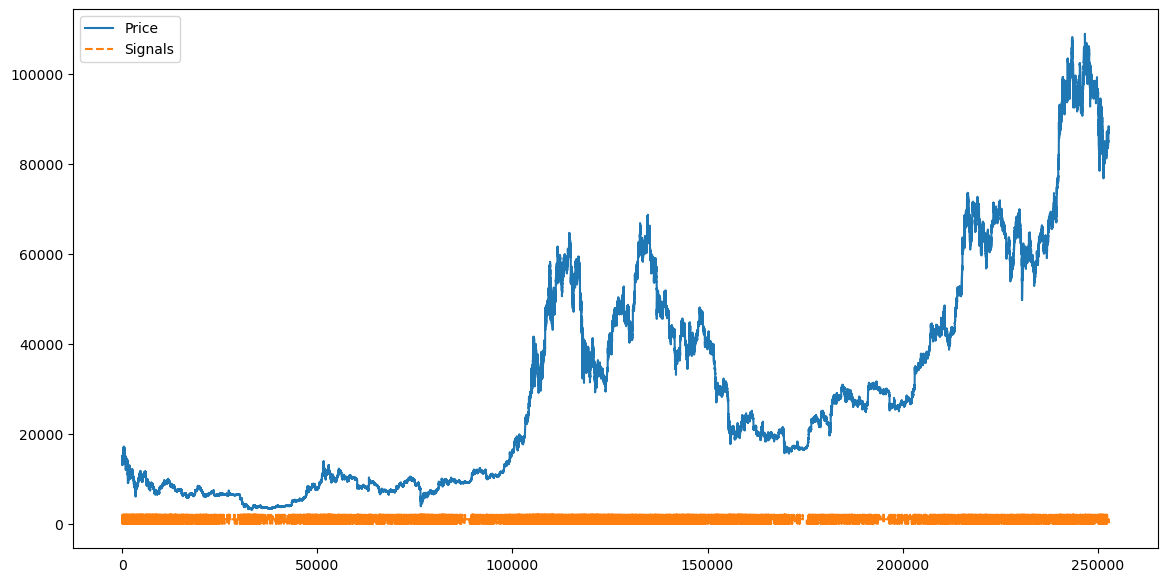

In [12]:
##plot price and signals
plt.figure(figsize=(14, 7))
plt.plot(price, label='Price')
plt.plot(signals * 1000, label='Signals', linestyle='dashed')
plt.legend()

plt.show()

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from positions import Positions
from order_class import BuyOrder, SellOrder

def backtest(prices: List[float], signals: List[int], stop_loss: float, take_profit: float,
             initial_capital: float = 10000, quantity: int = 1, last_n: int = None, transaction_fee_rate: float = 0.005) -> dict:
    """
    Backtest a trading strategy with visualizations and formatted results.
    """
    # ... [previous initialization code] ...

    # Initialize tracking for visualization
    capital_history = [initial_capital]
    closed_positions = []


    if last_n is not None:
        prices = prices[-last_n:].reset_index(drop=True)
        signals = signals[-last_n:]

    
    positions = Positions(initial_capital, transaction_fee_rate=transaction_fee_rate)
    
    for i, (price, signal) in enumerate(zip(prices, signals)):
        # Check and close existing positions
        positions.check_positions(price)
        
        # Open new position based on signal
        if signal == 0:  # Buy signal
            try:
                buy_order = BuyOrder(entry_price=price, quantity=quantity, stoploss=stop_loss, takeprofit=take_profit)
                positions.add_position(buy_order)
                # print("Buy signal at", price )
            except ValueError:
                pass  # Insufficient capital, skip this trade
        elif signal == 2:  # Sell signal
            sell_order = SellOrder(entry_price=price, quantity=quantity, stoploss=stop_loss, takeprofit=take_profit)
            positions.add_position(sell_order)
            # print("Sell signal at", price)
        # Track capital after each step
        capital_history.append(positions.get_current_capital())

    # ... [remaining position closing and result calculation code] ...
    # positions.close_all_positions(prices.iloc[-1])

    total_trades = positions.get_profit_count() + positions.get_loss_count()
    win_rate = positions.get_success_rate()
    profit_loss = positions.get_profit_loss()
    final_capital = positions.get_current_capital()
    total_return = (final_capital - initial_capital) / initial_capital * 100
    # Create formatted results table
    results = {
        "Total Trades": total_trades,
        "Win Rate (%)": f"{win_rate:.2f}",
        "Profit/Loss": f"${profit_loss:.2f}",
        "Initial Capital": f"${initial_capital:,.2f}",
        "Final Capital": f"${final_capital:,.2f}",
        "Return (%)": f"{total_return:.2f}%"
    }
    
    # Print formatted table
    print("📈 Backtest Results\n")
    print(pd.DataFrame.from_dict(results, orient='index').to_markdown(tablefmt="grid"))
    
    # # Create visualizations
    plt.figure(figsize=(14, 10))
    
    # Price and Signals Plot
    price_array = prices.values if isinstance(prices, pd.Series) else np.array(prices)
    signal_array = np.array(signals)

    plt.subplot(3, 1, 1)
    plt.plot(price_array, label='Price', color='navy')

    # Use boolean indexing for cleaner signal plotting
    buy_signals = np.where(signal_array == 0)[0]
    sell_signals = np.where(signal_array == 2)[0]

    plt.scatter(buy_signals, 
                price_array[buy_signals], 
                marker='^', color='lime', s=100, label='Buy Signal')
    plt.scatter(sell_signals, 
                price_array[sell_signals], 
                marker='v', color='red', s=100, label='Sell Signal')

    plt.title('Price Action with Trading Signals')
    plt.legend()
    plt.grid(True)

    # Equity Curve Plot
    plt.subplot(3, 1, 2)
    plt.plot(capital_history, color='darkgreen', linewidth=2)
    plt.title('Capital Evolution')
    plt.xlabel('Time Periods')
    plt.ylabel('Account Value')
    plt.grid(True)

    # Win/Loss Distribution
    plt.subplot(3, 1, 3)
    if total_trades > 0:
        labels = ['Profitable Trades', 'Losing Trades']
        sizes = [positions.get_profit_count(), positions.get_loss_count()]
        colors = ['#66b3ff', '#ff9999']
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, explode=(0.1, 0), shadow=True)
        plt.title('Trade Performance Distribution')
    else:
        plt.text(0.5, 0.5, 'No Trades Executed', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    print(positions.get_positions())

    return results


In [14]:
stloss = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
takeprofit = [tp*3 for tp in stloss]

In [15]:
signals.shape, price.shape

((252806,), (252806,))

In [16]:
for i in range(len(stloss)):
    st = stloss[i]
    tp = takeprofit[i]
    print(f"Stop loss: {st}")
    print(f"Take profit: {tp}")
    result = backtest(prices=price, signals=signals, stop_loss=st, take_profit=tp, initial_capital=100000, quantity=0.1, last_n=96*730, transaction_fee_rate=0.005)
    print("\n")

Stop loss: 0.001
Take profit: 0.003


TypeError: check_positions() missing 1 required positional argument: 'date'